# ARIMA Model
Autoregressive Integrated Moving Average. AKA Box-Jenkins approach. Based on the claim: non-stationary data can be made stationary by differentiating the series $Y_t$. ARIMA is popular model to forecast linear time series data.

Let's choose to analyse SHELL stock prices as they are the biggest UK company in terms of market cap.

In [74]:
import yfinance as yf

shell = yf.Ticker("shel.l")

shell_history = shell.history(period="5Y").reset_index()
shell_history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-12-24 00:00:00+00:00,1803.526508,1815.496817,1799.137395,1811.506714,2012674,0.0,0.0
1,2018-12-27 00:00:00+00:00,1831.457276,1831.457276,1775.196824,1795.147339,6637766,0.0,0.0
2,2018-12-28 00:00:00+00:00,1807.517101,1843.827047,1807.517101,1836.245850,5292536,0.0,0.0
3,2018-12-31 00:00:00+00:00,1843.826924,1853.004162,1833.851664,1841.432861,1746063,0.0,0.0
4,2019-01-02 00:00:00+00:00,1821.083483,1878.939992,1802.329994,1867.767700,5879309,0.0,0.0


In [75]:
df_close = shell_history.Close

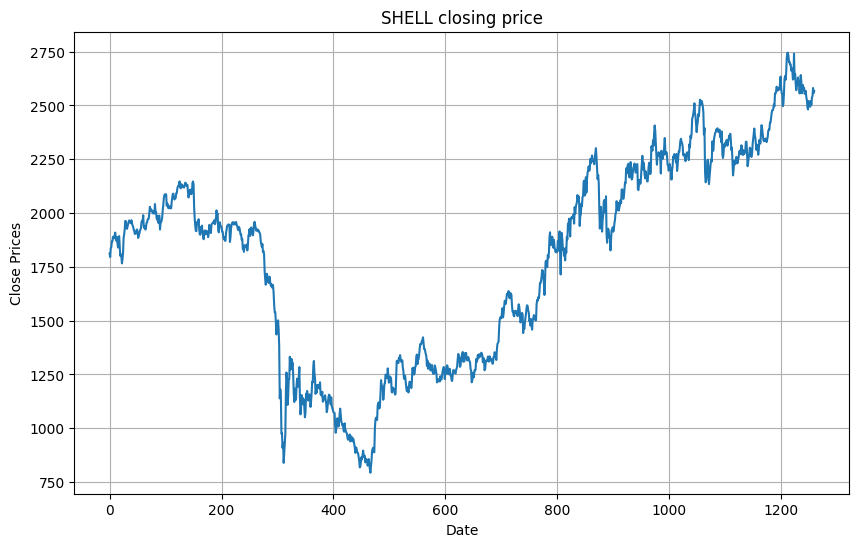

In [76]:
import matplotlib.pyplot as plt

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close)
plt.title('SHELL closing price')
plt.show()

Kernel density estimation (KDE) is a non-parametric way to estimate the PDF of a random variable.

<Axes: ylabel='Density'>

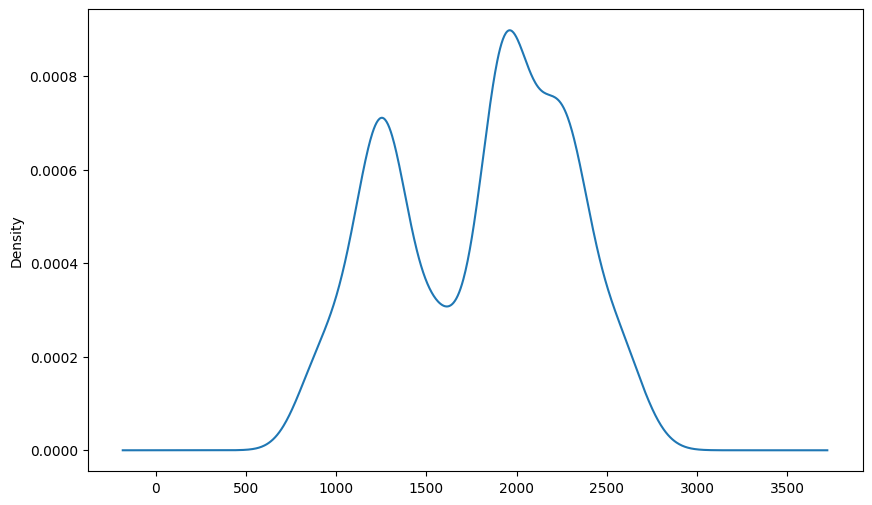

In [77]:
# Distribution of the dataset
df_close.plot(kind='kde')

Given a time series, it is thought to consist of 3 systematic components:
1. Level: average value in series
2. Trend: increasing or decreasing value in the series
3. Seasonality: the repeating short-term cycle in the series
And 1 non-systematic component:
1. Noise: random variation in the series

Time series analysis only works with stationary data so we must first check that with the ADF (Augmented Dickey-Fuller) test.

DF is a popular statistical test used to determine the presence of unit root in the series (hence help us understand if the series is stationary or not).

- Null hypothesis: series has unit root (value of $a=1$)
- Alternate hypothesis: series has no unit root

If we fail to reject the null hypothesis, we can say the series is non-stationary. This means the series is linear or difference stationary. If both mean and standard deviation are flat lines (i.e. const. mean and const. variance), the series becomes stationary.

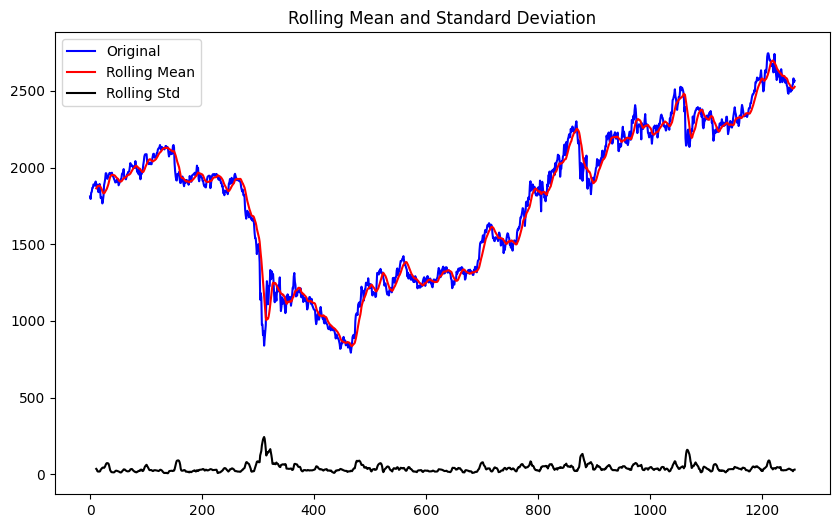

Results of dickey fuller test
Test Statistics                  -0.614694
p-value                           0.867627
No. of lags used                  2.000000
Number of observations used    1257.000000
critical value (1%)              -3.435563
critical value (5%)              -2.863842
critical value (10%)             -2.567996
dtype: float64


In [78]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

# Code from https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima/notebook

p-value is greater than 0.05 so we cannot reject the Null hypothesis (with 5% significance). Also, test statistic is greater than the critical values so data is non-stationary.

So let's separate Trend and Seasonality from the time series.

<Figure size 1000x600 with 0 Axes>

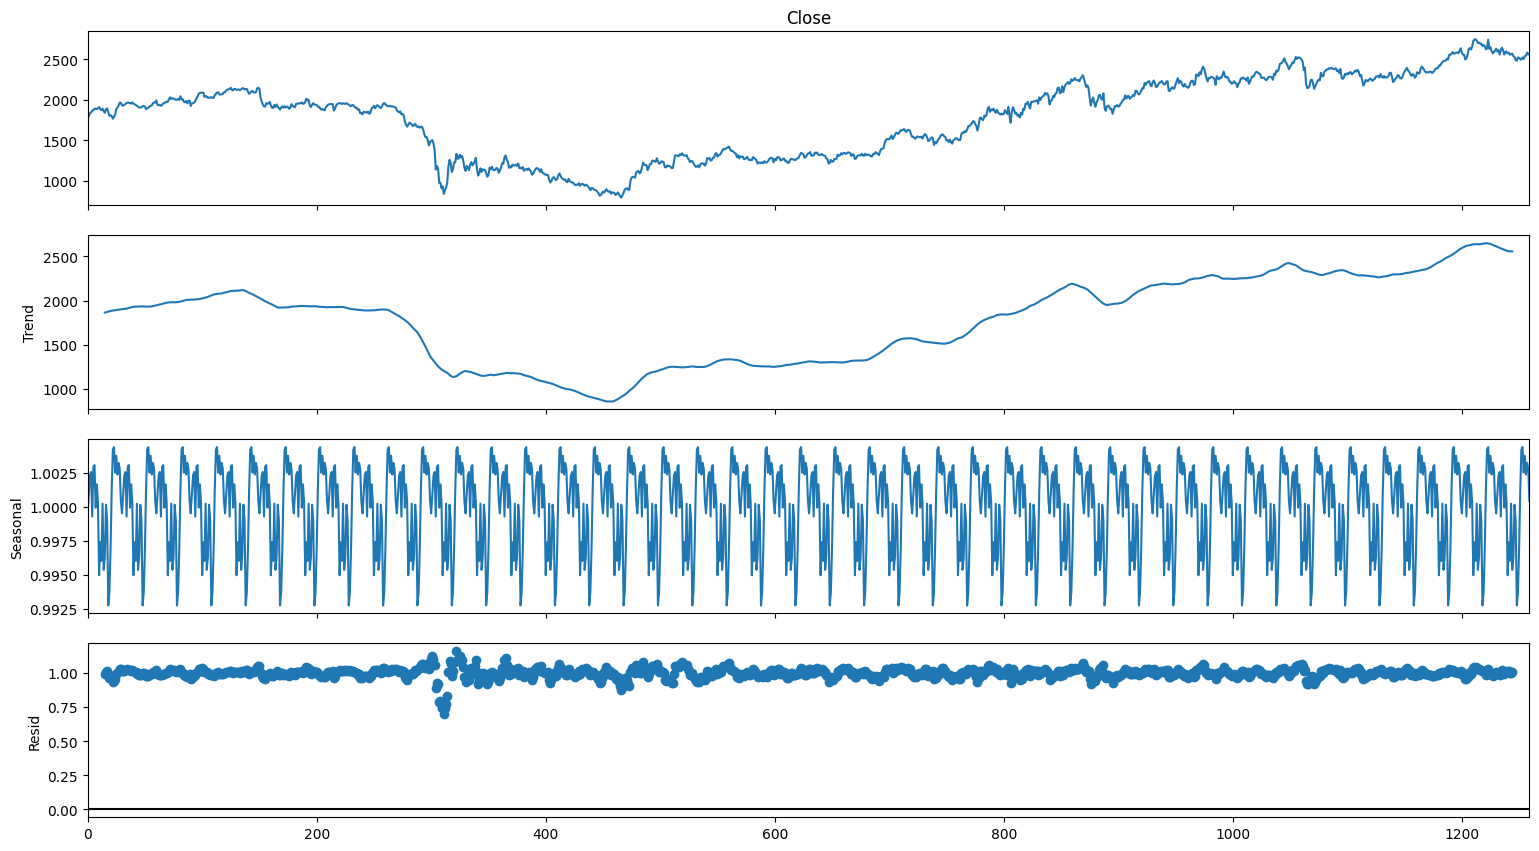

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# Code from https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima/notebook

Now let's take log of the series to reduce magnitude of values and reduce the rising trend. Then, we find the rolloing average (take input for past 12 months and give mean consumption value at every point further ahead in series).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


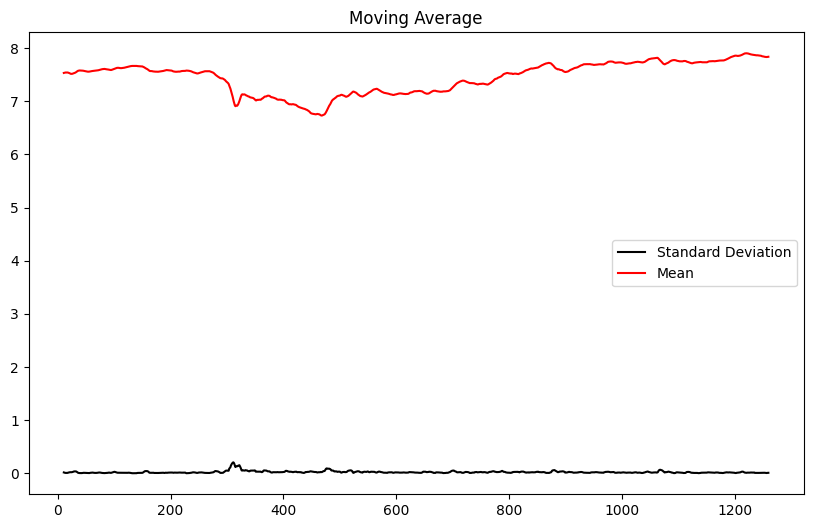

In [80]:
#if not stationary then eliminate trend
#Eliminate trend
import numpy as np
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now create ARIMA model.

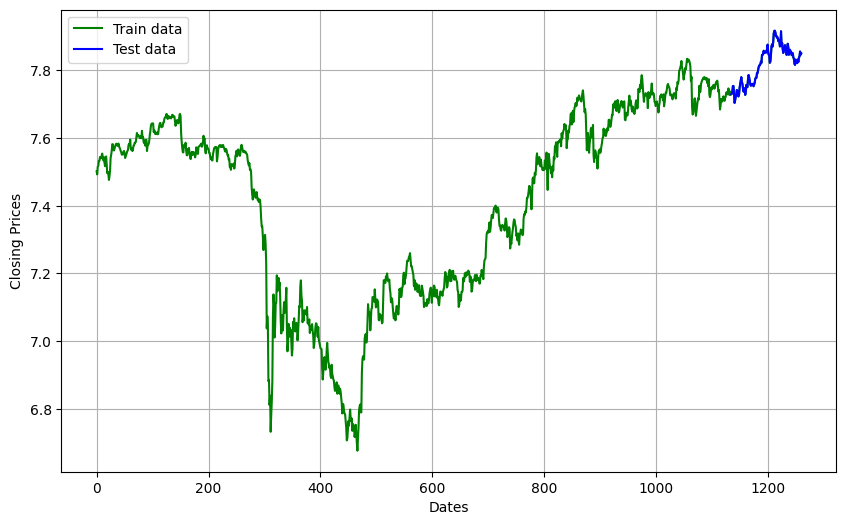

In [81]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

For our ARIMA model, we need to choose $p,q,d$. We can do so manually by observing the plots of ACF and PACF but we can instead use Auto ARIMA to get the best parameters without having to plot these graphs.

`auto_arima` seeks optimal parameters and returns a fitted ARIMA model. Works by conducting differencing tests (i.e. Kwiatkowski-Phillips-Schmidt-Shin, Augmented Dickey-Fuller or Phillips-Perron) to detereming the order of differencing, $d$, and then fitting models within ranges of defined `start_p`, `max_p`, `start_q`, `max_q` ranges. If seasonal optional is enabled, `auto_arima` also seeks to identify the optimal P and Q hyperparameters after conducting the Canova-Hansen test to determine the optimal order of seasonal differencing D.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-4615.951, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-4852.952, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-4617.951, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-4987.295, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-5077.054, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-5145.327, Time=0.09 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-5169.777, Time=0.22 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-5248.934, Time=0.94 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-5283.713, Time=0.74 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-5273.814, Time=0.58 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-5295.476, Time=0.67 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-5314.649, Time=0.84 sec
 ARIMA(1,2,2)(0,0,0)[0] interce

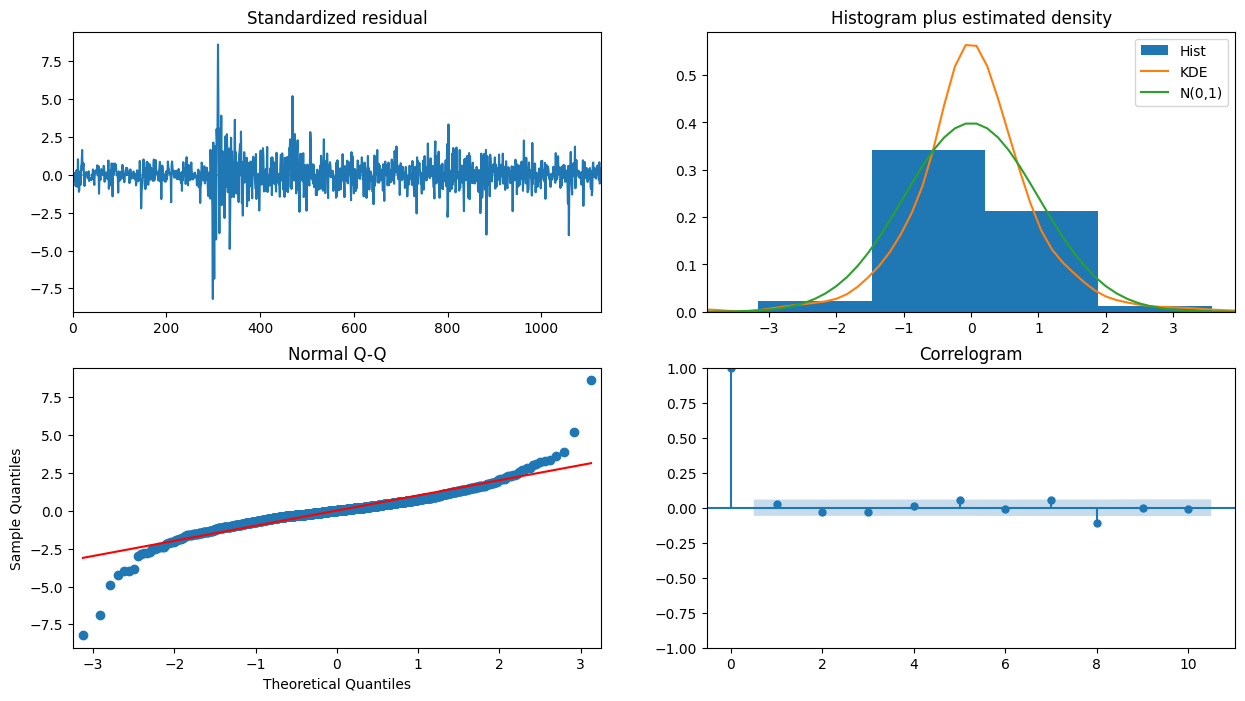

In [82]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      max_d=2,
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0,           # order of seasonal differencing, auto 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


How do we interpret the plots? (Todo: verify)
- Top left: residual errors seem to fluctuate around mean of zero and have uniform variance?
- Top right: suggests a normal distribution with mean zero
- Bottom left: all dots should fall on red line. Significant deviations implies distribution is skewed.
- Bottom right: The Correlogram, aka ACF plot, shows residula errors are not autocorrelated. Autocorrelation implies there is some pattern in residual errors which are not explained in the model (so we will need to look for more predictors to the model).

Overal seems to be a good fit, so create our ARIMA model with these parameters: `p,d,q=1,1,1`.

In [83]:
from statsmodels.tsa.arima.model import ARIMA

#Modeling
# Build Model
model = ARIMA(train_data, order=(4,2,3))  
fitted = model.fit() 
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1131
Model:                 ARIMA(4, 2, 3)   Log Likelihood                2675.893
Date:                Tue, 26 Dec 2023   AIC                          -5335.787
Time:                        14:39:59   BIC                          -5295.554
Sample:                             0   HQIC                         -5320.586
                               - 1131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5527      0.067    -23.279      0.000      -1.683      -1.422
ar.L2         -0.7688      0.068    -11.371      0.000      -0.901      -0.636
ar.L3         -0.0922      0.032     -2.860      0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now let's forecast stock prices on test, keeping 95% confidence level.

In [84]:
# Obtain forecast
forecast_result = fitted.get_forecast(steps=len(test_data))

# Get the forecasted values
fc = forecast_result.predicted_mean

# Get the standard error
se = forecast_result.se_mean

# Get the confidence intervals
conf = forecast_result.conf_int(alpha=0.05)


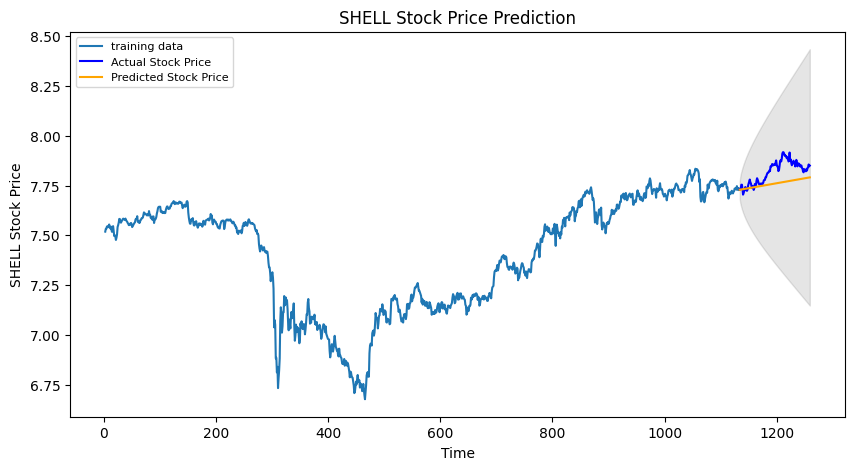

In [85]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf['lower Close'], index=test_data.index)
upper_series = pd.Series(conf['upper Close'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SHELL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SHELL Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Let's look at some commonly used accuracy metrics

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.005159231671715042
MAE: 0.05882646011470137
RMSE: 0.07182779177807878
MAPE: 0.007489822484237098


Our x% MAPE implies the model is y% accuracte in predicting the next n observations.

Next steps: Create an ARIMA based trading strategy and analyse the strategy performance
Now, you can create an ARIMA based trading strategy using the predictions made.
After the strategy is created, you can analyse the performance of the strategy.
The output will give you Sharpe Ratio, cumulative return and the maximum drawdown.
The strategy performance will look like this as the plotted graph.

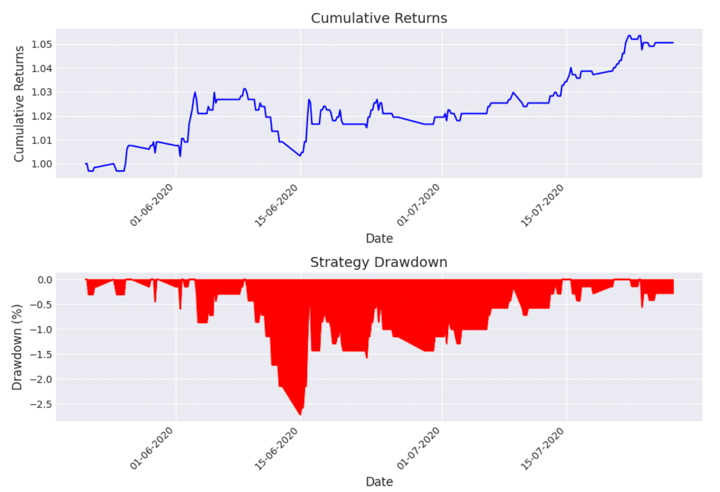

Pros of using ARIMA model in trading
- Captures Time-dependent Patterns: The ARIMA model is effective at capturing trends, seasonality, and other temporal patterns in time series data, providing valuable insights into market behaviour.
- Proven Methodology: ARIMA is a well-established and widely used modelling technique in time series analysis, with a solid foundation in statistics. It has been successfully applied in various domains, including trading.
- Interpretability: ARIMA models provide interpretable results, allowing traders to understand the relationship between past and future price movements and make informed decisions based on the model's coefficients and statistical measures.
- Handles Non-stationarity: The ARIMA model's integration component (the "I" in ARIMA) helps transform non-stationary data into stationary form, addressing one of the challenges often encountered in financial time series analysis.

Cons of using ARIMA model in trading
- Limited Complexity: ARIMA models assume linear relationships and may struggle to capture complex or nonlinear patterns in financial markets. They might not fully capture sudden changes or rare events that can significantly impact prices.
- Data Quality and Assumptions: ARIMA models require high-quality data and rely on assumptions such as stationarity and normality. Violations of these assumptions can affect the model's accuracy and reliability.
- Limited Incorporation of External Factors: ARIMA models primarily focus on historical price data and may not readily incorporate external factors such as news events, economic indicators, or market sentiment that can influence price movements.
- Short-term Focus: ARIMA models tend to be better suited for short-term forecasting rather than long-term predictions. They may struggle to capture longer-term trends or shifts in market dynamics.


(From https://blog.quantinsti.com/forecasting-stock-returns-using-arima-model/)
